# Classification of MRI images using CNN for tumour detection
## (Part 1 - Running the models)

We will start by downloading the dataset from the Github repository and unzipping the contents of the repository into our local directory.

In [1]:
!wget https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/refs/heads/master.zip
!unzip -q master.zip

--2022-04-21 10:24:44--  https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/zip/refs/heads/master [following]
--2022-04-21 10:24:44--  https://codeload.github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [                <=> ]  86.97M  25.6MB/s    in 3.5s    

2022-04-21 10:24:48 (25.0 MB/s) - ‘master.zip’ saved [91198591]



Let us now set the path to the directories containing the training and the validation images.

In [2]:
import pandas as pd
TRAIN_PATH = "./Brain-Tumor-Classification-DataSet-master/Training/"
TEST__PATH = "./Brain-Tumor-Classification-DataSet-master/Testing/"

We will now set the batch and the image size for the models.

In [3]:
import tensorflow as tf
batch_size = 32
img_height = 256
img_width = 256

We will now create the input pipeline Tensorflow-compatible dataset using the images in the training directory.

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
  TRAIN_PATH,
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2870 files belonging to 4 classes.


Let us similarly create a dataset using the images in the validation directory.

In [5]:
testing_dataset = tf.keras.utils.image_dataset_from_directory(
  TEST__PATH,
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 394 files belonging to 4 classes.


Let us view the names of the classes in the dataset(s).

In [6]:
classes = training_dataset.class_names
print(classes)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


For our own visualization, let us plot a few of the images, along with their labels, from the dataset.

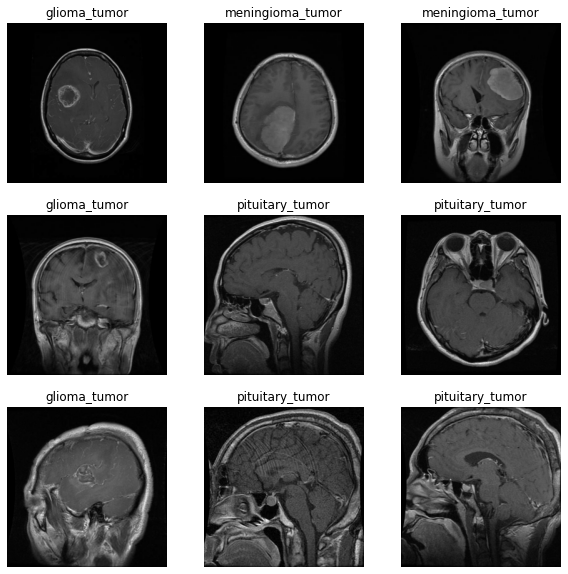

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

Let us configure Tensorflow to enable buffering for efficiency.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Let us define a callback for early stopping so that the training can be automatically stopped in case there is no decrease in validation loss.

We will add a tolerance of five (5) eopchs so that the training does not terminate in case the model is stuck in a plateau.

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

Let us create a variable to indicate the maximum number of epochs allowed for training the models.

In [10]:
MAX_EPOCHS = 100

## Model 1 - Basic Model

Let us define and build the basic model

In [11]:
basic_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4)
])

basic_model.build(input_shape=(None,256,256,3))
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9

We will now compile and train the model.

In [12]:
basic_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

basic_history = basic_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Epoch 1/100
90/90 [==============================] - 23s 140ms/step - loss: 0.9581 - accuracy: 0.5895 - val_loss: 2.1080 - val_accuracy: 0.4112
Epoch 2/100
90/90 [==============================] - 10s 116ms/step - loss: 0.5170 - accuracy: 0.7927 - val_loss: 1.9657 - val_accuracy: 0.5990
Epoch 3/100
90/90 [==============================] - 11s 117ms/step - loss: 0.3535 - accuracy: 0.8648 - val_loss: 2.1022 - val_accuracy: 0.6827
Epoch 4/100
90/90 [==============================] - 11s 117ms/step - loss: 0.2145 - accuracy: 0.9167 - val_loss: 2.4687 - val_accuracy: 0.7234
Epoch 5/100
90/90 [==============================] - 11s 118ms/step - loss: 0.1589 - accuracy: 0.9418 - val_loss: 2.8541 - val_accuracy: 0.7056
Epoch 6/100
90/90 [==============================] - 10s 117ms/step - loss: 0.0991 - accuracy: 0.9627 - val_loss: 2.3946 - val_accuracy: 0.7614
Epoch 7/100
90/90 [==============================] - 11s 117ms/step - loss: 0.0693 - accuracy: 0.9721 - val_loss: 4.1143 - val_accuracy:

Save the model and training history

In [13]:
basic_model.save("/content/drive/MyDrive/mri-cnn/basic")
pd.DataFrame(basic_history.history).to_csv("/content/drive/MyDrive/mri-cnn/basic.csv")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/mri-cnn/basic/assets


##Model 2 - ResNet50

Let us import the ResNet50 model.

In [14]:
resnet50_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=(256,256,3)))
resnet50_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

We will flatten the final layer and then add our output layer with four (4) nodes.

In [15]:
res_model = tf.keras.models.Sequential()
res_model.add(resnet50_model)
res_model.add(tf.keras.layers.Flatten())
res_model.add(tf.keras.layers.Dense(4))
res_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 4)                 524292    
                                                                 
Total params: 24,112,004
Trainable params: 24,058,884
Non-trainable params: 53,120
_________________________________________________________________


We can finally compile and train the ResNet50 model.

In [16]:
res_model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
res_history = res_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Epoch 1/100
90/90 [==============================] - 106s 1s/step - loss: 4.1462 - accuracy: 0.6819 - val_loss: 116763.5469 - val_accuracy: 0.1878
Epoch 2/100
90/90 [==============================] - 91s 1s/step - loss: 2.5822 - accuracy: 0.7122 - val_loss: 3094.9524 - val_accuracy: 0.2259
Epoch 3/100
90/90 [==============================] - 91s 1s/step - loss: 1.4928 - accuracy: 0.7906 - val_loss: 4.3669 - val_accuracy: 0.4721
Epoch 4/100
90/90 [==============================] - 91s 1s/step - loss: 1.0423 - accuracy: 0.8317 - val_loss: 4.4313 - val_accuracy: 0.4213
Epoch 5/100
90/90 [==============================] - 91s 1s/step - loss: 0.6095 - accuracy: 0.8718 - val_loss: 2.7224 - val_accuracy: 0.5711
Epoch 6/100
90/90 [==============================] - 91s 1s/step - loss: 1.5753 - accuracy: 0.8021 - val_loss: 744407.5000 - val_accuracy: 0.2944
Epoch 7/100
90/90 [==============================] - 91s 1s/step - loss: 1.9975 - accuracy: 0.7432 - val_loss: 3523.3513 - val_accuracy: 0.2

Save the model and training history

In [17]:
res_model.save("/content/drive/MyDrive/mri-cnn/res")
pd.DataFrame(res_history.history).to_csv("/content/drive/MyDrive/mri-cnn/res.csv")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/mri-cnn/res/assets


##Model 3 - VGG16

Let us import the VGG16 model.

In [18]:
vgg16_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=(256,256,3)))
vgg16_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

Like before, let us add our output layers.

In [19]:
vgg_model = tf.keras.models.Sequential()
vgg_model.add(vgg16_model)
vgg_model.add(tf.keras.layers.Flatten())
vgg_model.add(tf.keras.layers.Dense(4))
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 131076    
                                                                 
Total params: 14,845,764
Trainable params: 14,845,764
Non-trainable params: 0
_________________________________________________________________


We are now ready to compile and train the network.

In [ ]:
vgg_model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
vgg_history = vgg_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Epoch 1/100
90/90 [==============================] - 144s 1s/step - loss: 5.0111 - accuracy: 0.4662 - val_loss: 1.9138 - val_accuracy: 0.3223
Epoch 2/100
90/90 [==============================] - 119s 1s/step - loss: 0.9095 - accuracy: 0.6080 - val_loss: 1.9107 - val_accuracy: 0.3274
Epoch 3/100
90/90 [==============================] - 119s 1s/step - loss: 0.7668 - accuracy: 0.6774 - val_loss: 1.9524 - val_accuracy: 0.3426
Epoch 4/100
90/90 [==============================] - 118s 1s/step - loss: 0.6836 - accuracy: 0.7160 - val_loss: 2.0521 - val_accuracy: 0.3452
Epoch 5/100
90/90 [==============================] - 118s 1s/step - loss: 0.5998 - accuracy: 0.7589 - val_loss: 2.4187 - val_accuracy: 0.3147
Epoch 6/100
90/90 [==============================] - 119s 1s/step - loss: 0.5574 - accuracy: 0.7791 - val_loss: 1.9908 - val_accuracy: 0.3985
Epoch 7/100
86/90 [===========================>..] - ETA: 5s - loss: 0.4837 - accuracy: 0.8205

Save the model and training history

In [ ]:
vgg_model.save("/content/drive/MyDrive/mri-cnn/vgg")
pd.DataFrame(vgg_history.history).to_csv("/content/drive/MyDrive/mri-cnn/vgg.csv")

##Model 4 - MobileNet

We will now import the MobileNet architecture.

In [ ]:
mobilenet_model = tf.keras.applications.MobileNet(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=(256,256,3)))
mobilenet_model.summary()

Let us put our application-specific output layer into the imported architecture.

In [ ]:
mobile_model = tf.keras.models.Sequential()
mobile_model.add(mobilenet_model)
mobile_model.add(tf.keras.layers.Flatten())
mobile_model.add(tf.keras.layers.Dense(4))
mobile_model.summary()

We can now compile and train our network.

In [ ]:
mobile_model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
mobile_history = mobile_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Save the model and training history

In [ ]:
mobile_model.save("/content/drive/MyDrive/mri-cnn/mobile")
pd.DataFrame(mobile_history.history).to_csv("/content/drive/MyDrive/mri-cnn/mobile.csv")

##Model 5 - Inception v3

Let us load the InceptionNetv3 model.

In [ ]:
inceptionnet_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet", input_tensor = tf.keras.Input(shape=(256,256,3)))
inceptionnet_model.summary()

As before, we will add our application-specific output layer with four (4) nodes.

In [ ]:
inception_model = tf.keras.models.Sequential()
inception_model.add(inceptionnet_model)
inception_model.add(tf.keras.layers.Flatten())
inception_model.add(tf.keras.layers.Dense(4))
inception_model.summary()

We are ready to compile and train the neural network.

In [ ]:
inception_model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
inception_history = inception_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Save the model and training history

In [ ]:
inception_model.save("/content/drive/MyDrive/mri-cnn/inception")
pd.DataFrame(inception_history.history).to_csv("/content/drive/MyDrive/mri-cnn/inception.csv")

##Model 6 - AlexNet

The Tensorflow core applications have no prebuilt model for AlexNet.

We will build the model on our own.

In [ ]:
alexnet_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

alexnet_model.build(input_shape=(None,256,256,3))
alexnet_model.summary()

Let us compile and train the AlexNet model.

In [ ]:
alexnet_model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
alexnet_history = alexnet_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Save the model and training history

In [ ]:
alexnet_model.save("/content/drive/MyDrive/mri-cnn/alexnet")
pd.DataFrame(alexnet_history.history).to_csv("/content/drive/MyDrive/mri-cnn/alexnet.csv")

#Model 7 - LeNet

Like AlexNet, Tensorflow does not have a prebuilt model for LeNet. Therefore, we will define the model on our own.

In [ ]:
lenet_model = tf.keras.Sequential()
lenet_model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)))
lenet_model.add(tf.keras.layers.AveragePooling2D())
lenet_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
lenet_model.add(tf.keras.layers.AveragePooling2D())
lenet_model.add(tf.keras.layers.Flatten())
lenet_model.add(tf.keras.layers.Dense(units=120, activation='relu'))
lenet_model.add(tf.keras.layers.Dense(units=84, activation='relu'))
lenet_model.add(tf.keras.layers.Dense(units=4))

We are now ready to compile and train LeNet

In [ ]:
lenet_model.compile(optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
lenet_history = lenet_model.fit(
  training_dataset,
  validation_data=testing_dataset,
  epochs=MAX_EPOCHS,
  callbacks=[es]
)

Save the model and training history

In [ ]:
lenet_model.save("/content/drive/MyDrive/mri-cnn/lenet")
pd.DataFrame(lenet_history.history).to_csv("/content/drive/MyDrive/mri-cnn/lenet.csv")

## Conclusion

We have used the following models for the MRI tumour classification task -
1. Basic CNN
2. ResNet50
3. VGG16
4. MobileNet
5. InceptionNet v2
6. AlexNet
7. LeNet

We splitted the dataset into training and validation sets. Once splitted, we trained the different models using the training set.

We used the validation set to determine the training performance at the end of each epoch.

We used early stopping with a high tolerance to stop the training earlier than the scheduled time in case the training was stuck in a minima without further improvement in performance.

We have saved the models trained and the training histories for further analysis.